# Lesson4 ニューラル翻訳モデルを作ってみよう（Seq2Seq, Attention）

## 目次

- Section1 Checkクイズの解答
- Section2 実装①
    - 2.0 データの用意
    - 2.1 モデル構築
    - 2.2 モデルの学習
    - 2.3 モデルによる予測
    - 2.4 モデルの可視化
    - 2.5 機械翻訳の評価について（補足）

## Section1 Checkクイズの解答

問題1: 3, 問題2: 1, 問題3; 2, 問題4: 3

## Section2 実装①

LSTMを使ったSeq2Seqモデルで英日機械翻訳を行ってみましょう。

使用するデータセット、train.enとtrain.jaの中身は次のようになっています.

train.enの中身 (英語の文)
```
i can 't tell who will arrive first .
many animals have been destroyed by men .
i 'm in the tennis club .
︙
```

train.jaの中身(日本語の文, 対訳)
```
誰 が 一番 に 着 く か 私 に は 分か り ま せ ん 。
多く の 動物 が 人間 に よ っ て 滅ぼ さ れ た 。
私 は テニス 部員 で す 。
︙
```
(データセットにはTanaka Corpus ( http://www.edrdg.org/wiki/index.php/Tanaka_Corpus )の一部を抽出した 
small_parallel_enja: 50k En/Ja Parallel Corpus for Testing SMT Methods ( https://github.com/odashi/small_parallel_enja ) を使っています.)

### 2.0 データの用意

まずはデータの読み込みです。

読み込む際、文頭を表す仮想単語（**BOS**, Beginning Of Sentence）として`<s>`、文末を表す仮想単語（**EOS**, End Of Sentence）として`<\s>`を付加します。

また、BOS, EOSをつけた文章について、Tokenizerによって数値化を行います。

最後に、バッチ処理のため、各系列の長さをそろえておきます。これには`keras.preprocessing.sequence.pad_sequences`を用います。

詳しくは、https://keras.io/ja/preprocessing/sequence/#pad_sequences を参照してください。

<img src='figures/preprocess.png' width='80%'>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

def load_data(file_path):
    tokenizer = Tokenizer(filters="")
    whole_texts = []
    for line in open(file_path, encoding='utf-8'):
        whole_texts.append("<s> " + line.strip() + " </s>")
        
    tokenizer.fit_on_texts(whole_texts)
    
    return tokenizer.texts_to_sequences(whole_texts), tokenizer

# 読み込み＆Tokenizerによる数値化
x_train, tokenizer_en = load_data('/content/gdrive/MyDrive/dl4us/dl4us-master/lesson4/data/train.en')
y_train, tokenizer_ja = load_data('/content/gdrive/MyDrive/dl4us/dl4us-master/lesson4/data/train.ja')

en_vocab_size = len(tokenizer_en.word_index) + 1
ja_vocab_size = len(tokenizer_ja.word_index) + 1

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.02, random_state=42)

# パディング
x_train = pad_sequences(x_train, padding='post')
y_train = pad_sequences(y_train, padding='post')

seqX_len = len(x_train[0])
seqY_len = len(y_train[0])

### 2.1 モデル構築

ここでは、LSTMを使用してSeq2Seqモデルを構築します。

Embeddingレイヤーでは`mask_zero=True`を引数として指定することで、計算上先程のパディング部分を無視するようにしています。

また、Recurrentレイヤーに対する`return_state=True`や`return_sequences=True`の指定をLSTMレイヤーの生成時に行っています。

なお、Functional APIによるモデル構築であることに注意してください。

<img src='figures/model.png'>

なお、図の各レイヤーは以下のように対応することに注意してください。

1. 符号化器Embeddingレイヤー： EncoderのEmbedding
2. 符号化器再帰レイヤー：　Encoder(LSTM)
3. 復号化器Embeddingレイヤー： DecoderのEmbedding
4. 復号化器再帰レイヤー： Decoder(LSTM)
5. 復号化器出力レイヤー： Dense

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM

emb_dim = 256
hid_dim = 256

## 符号化器
# Inputレイヤー（返り値としてテンソルを受け取る）
encoder_inputs = Input(shape=(seqX_len,))

# モデルの層構成（手前の層の返り値テンソルを、次の接続したい層に別途引数として与える）
# InputレイヤーとEmbeddingレイヤーを接続（+Embeddingレイヤーのインスタンス化）
encoder_embedded = Embedding(en_vocab_size, emb_dim, mask_zero=True)(encoder_inputs) # shape: (seqX_len,)->(seqX_len, emb_dim)
# EmbeddingレイヤーとLSTMレイヤーを接続（+LSTMレイヤーのインスタンス化）
_, *encoder_states = LSTM(hid_dim, return_state=True)(encoder_embedded)  # shape: (seqX_len, emb_dim)->(hid_dim, )
# このLSTMレイヤーの出力に関しては下記に補足あり

In [ ]:
## 復号化器
# Inputレイヤー（返り値としてテンソルを受け取る）
decoder_inputs = Input(shape=(seqY_len,))

# モデルの層構成（手前の層の返り値テンソルを、次の接続したい層に別途引数として与える）
# InputレイヤーとEmbeddingレイヤーを接続
decoder_embedding = Embedding(ja_vocab_size, emb_dim) # 後で参照したいので、レイヤー自体を変数化
decoder_embedded = decoder_embedding(decoder_inputs)  # shape: (seqY_len,)->(seqY_len, emb_dim)
# EmbeddingレイヤーとLSTMレイヤーを接続（encoder_statesを初期状態として指定）
decoder_lstm = LSTM(hid_dim, return_sequences=True, return_state=True) # 後で参照したいので、レイヤー自体を変数化
decoder_outputs, _, _ = decoder_lstm(decoder_embedded, initial_state=encoder_states) # shape: (seqY_len, emb_dim)->(seqY_len, hid_dim)
# LSTMレイヤーとDenseレイヤーを接続
decoder_dense = Dense(ja_vocab_size, activation='softmax') # 後で参照したいので、レイヤー自体を変数化
decoder_outputs = decoder_dense(decoder_outputs) # shape: (seqY_len, hid_dim)->(seqY_len, ja_vocab_size)

# モデル構築（入力は符号化器＆復号化器、出力は復号化器のみ）
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
# 今回は、sparse_categorical_crossentropy（正解ラベルとしてone_hot表現のベクトルでなく数値を受け取るcategorical_crossentropy）を使用

#### LSTMレイヤーの補足

LSTMの出力に関して補足の説明をします。以下の図はLSTMの模式図です。

<img src='../figures/lstm.png' width='50%'>

**1. LSTMレイヤーはオプションがない場合はレイヤーの出力を返します。**

```
output = LSTM()(x)
```

なお、このときの出力(output)とはLSTMの最後の隠れ状態$h$のことを指します。

図を3timestepとみる場合は $h_{t+2}$にあたります。

**2.  引数に`return_state=True`を指定されているときは隠れ状態も返します。**

```
output, state_h, state_c = LSTM(return_state=True)(x)
```

このときの`state_h`と`state_c`はそれぞれLSTMの最後の隠れ状態$h$とセル状態$c$となります。

図を3timestepとみる場合は `state_h`は $h_{t+2}$ 、`state_c`は$c_{t+2}$にあたります。

このとき、`output=state_h`となっていることに注意してください。

また、以下のコードを説明すると、

```
_, *encoder_states = LSTM(hid_dim, return_state=True)(encoder_embedded)
```

outputは今回は参照しないので`_`(アンダーバー)を使っており、`*`(スター)を使うことで`encoder_states=[state_h, state_c]`となるような代入を行っています。このような使い方はpython一般の使い方ですので疑問に思った方はpythonの復習をおすすめします。

**3.  引数に`return_sequences=True`を指定されているときは系列も返します。**

```
outputs, state_h, state_c = LSTM(return_state=True, return_sequences=True)(x)
```

このとき`outputs`は系列すべての出力を含みます。

図を3timestepとみる場合は、`outputs`に $h_{t}$、$h_{t+1}$、$h_{t+2}$のすべての出力を含むということになります。

### 2.2 モデルの学習

モデルの学習時には、教師データとして1時点先の単語を示すデータを入力します。(`train_target`)

学習時にはDecoderの入力に教師データを用います。

<img src='figures/training.png'>

In [ ]:
import numpy as np

train_target = np.hstack((y_train[:, 1:], np.zeros((len(y_train),1), dtype=np.int32)))

model.fit([x_train, y_train], np.expand_dims(train_target, -1), batch_size=64, epochs=5, verbose=2, validation_split=0.2)

Epoch 1/5
613/613 - 446s - loss: 2.6017 - val_loss: 2.0712
Epoch 2/5
613/613 - 446s - loss: 1.9011 - val_loss: 1.7967
Epoch 3/5
613/613 - 446s - loss: 1.6806 - val_loss: 1.6476
Epoch 4/5
613/613 - 441s - loss: 1.5287 - val_loss: 1.5380
Epoch 5/5
613/613 - 442s - loss: 1.4086 - val_loss: 1.4526


### 2.3 モデルによる生成

先程学習したモデルを使用して、系列を生成してみましょう。

そのためにまずは学習したモデルを組み込んだ、系列生成用のモデルを構築します。

学習時との違いは、復号化器が1ステップずつ実行できるよう、状態ベクトルの入力と出力をモデルの定義に加えている点です。

(また、1ステップ前の状態を引き継いで生成が可能になるように、復号化器のモデルの初期状態を指定可能にしています。)

生成する際のDecoderの入力には翻訳先の教師データは用いません。

<img src='figures/prediction.png'>

In [ ]:
# サンプリング用（生成用）のモデルを作成

# 符号化器（学習時と同じ構成、学習したレイヤーを利用）
encoder_model = Model(encoder_inputs, encoder_states)

# 復号化器
decoder_states_inputs = [Input(shape=(hid_dim,)), Input(shape=(hid_dim,))] # decorder_lstmの初期状態指定用(h_t, c_t)

decoder_inputs = Input(shape=(1,))
decoder_embedded = decoder_embedding(decoder_inputs) # 学習済みEmbeddingレイヤーを利用
decoder_outputs, *decoder_states = decoder_lstm(decoder_embedded, initial_state=decoder_states_inputs) # 学習済みLSTMレイヤーを利用
decoder_outputs = decoder_dense(decoder_outputs) # 学習済みDenseレイヤーを利用

decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

このモデルを使用した生成（予測）を行ってみましょう。

生成では、未知のデータに対してモデルを適用するので正解ラベルはわかりません。

そこで、代わりに前のステップで予測した単語を各ステップでの入力とします。

そして, 系列の終わりを表す単語 (`</s>`) が出力されるまで繰り返します。（最初の入力は`<s>`を使用します）

In [ ]:
def decode_sequence(input_seq, bos_eos, max_output_length = 1000):
    states_value = encoder_model.predict(input_seq)

    target_seq = np.array(bos_eos[0])  # bos_eos[0]="<s>"に対応するインデックス
    output_seq= bos_eos[0][:]
    
    while True:
        output_tokens, *states_value = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = [np.argmax(output_tokens[0, -1, :])]
        output_seq += sampled_token_index
        
        if (sampled_token_index == bos_eos[1] or len(output_seq) > max_output_length):
            break

        target_seq = np.array(sampled_token_index)

    return output_seq

In [ ]:
detokenizer_en = dict(map(reversed, tokenizer_en.word_index.items()))
detokenizer_ja = dict(map(reversed, tokenizer_ja.word_index.items()))

text_no = 0
input_seq = pad_sequences([x_test[text_no]], seqX_len, padding='post')
bos_eos = tokenizer_ja.texts_to_sequences(["<s>", "</s>"])

print('元の文:', ' '.join([detokenizer_en[i] for i in x_test[text_no]]))
print('生成文:', ' '.join([detokenizer_ja[i] for i in decode_sequence(input_seq, bos_eos)]))
print('正解文:', ' '.join([detokenizer_ja[i] for i in y_test[text_no]]))

元の文: <s> you may extend your stay in tokyo . </s>
生成文: <s> あなた は 東京 に 住 ん で い る よ 。 </s>
正解文: <s> 東京 滞在 を 延ば し て も い い で す よ 。 </s>


### 2.4 モデルの可視化

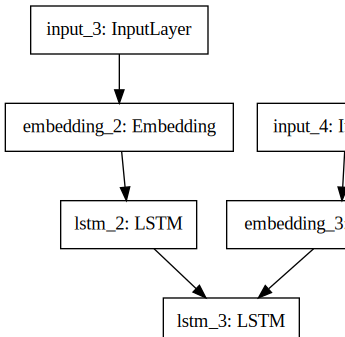

In [ ]:
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

### 2.5 機械翻訳の評価について（補足）

これまで、基本的に学習したモデルの良し悪しについては損失をベースに考えてきました。

ですが機械翻訳の場合、損失と翻訳の精度が必ずしも一致しません。

というのも、翻訳においては、単純に各単語が一致しているか否か以上に、意味的な繋がりや表現の流暢さが重要となるためです。

また、必ずしも語順についても一致している必要はありません。

そこで、そうした翻訳タスク特有の性質を反映した評価指標が必要となります。その代表例として、**BLEUスコア**が挙げられます。

BLEUスコアは、n-gram（連続n単語. 主にn=4）がどれだけ生成文と正解文で共有されているかなどを考慮した指標となっています。

機械翻訳は本講座の主目的ではないので、ここではその詳細な算出方法等は触れませんが、興味がある方はスクリプト（http://www.nltk.org/_modules/nltk/translate/bleu_score.html ）をのぞいてみてください。

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

prediction = ['I', 'am', 'a', 'graduate', 'student', 'at', 'a', 'university']
reference = [['I', 'am', 'a', 'graduate', 'student', 'at', 'the', 'university', 'of', 'tokyo']]

print(sentence_bleu(reference, prediction))

0.5506953149031837


In [ ]:
text_no = 1
input_seq = pad_sequences([x_test[text_no]], seqX_len, padding='post')
bos_eos = tokenizer_ja.texts_to_sequences(["<s>", "</s>"])

prediction = [detokenizer_ja[i] for i in decode_sequence(input_seq, bos_eos)]
reference = [[detokenizer_ja[i] for i in y_test[text_no]]]

print(prediction)
print(reference)

print(sentence_bleu(reference, prediction))

['<s>', '私', 'は', '学校', 'に', '行', 'く', '。', '</s>']
[['<s>', '私', 'は', '学校', 'で', '勉強', 'する', '。', '</s>']]
0.3549481056010053


このBLEUスコアの他にも、機械翻訳の評価指標がいくつか提案されています。

代表的なものの比較は、

N. Graham, "文レベルの機械翻訳評価尺度に関する調査", 研究報告自然言語処理, vol. 2013-NL-212, no. 7, pp. 1–8, 2013. (http://phontron.com/paper/neubig13nl212.pdf)

などにまとめられているので、機械翻訳に興味のあるかたは参照してみてください。